In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### My own functions

In [0]:
def plot_hist(df, col, label):
    plt.hist(df[col], label = label)
    plt.legend()
    plt.show()

### 1. Data Preparation

In [0]:
# General imports
import numpy as np
np.random.seed(0)
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os, sys, gc, warnings, random, datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import math

warnings.filterwarnings('ignore')

In [0]:
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
## ------------------- 

## -------------------
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
## -------------------

In [0]:
SEED = 42
seed_everything(SEED)
TARGET = 'isFraud'

In [6]:
# ----- Load Data -------
#os.chdir("/Users/jack/Desktop/Data Science/Notebooks/Springboard/Capstone2/ieee_data")

print('Loading Data..')

train_df = pd.read_csv('/content/drive/My Drive/Springboard Capstone 2/train_transaction.csv')#('train_transaction.csv')#
test_df = pd.read_csv('/content/drive/My Drive/Springboard Capstone 2/test_transaction.csv')#('test_transaction.csv')#
test_df['isFraud'] = 0

train_identity = pd.read_csv('/content/drive/My Drive/Springboard Capstone 2/train_identity.csv')#('train_identity.csv')#
test_identity = pd.read_csv('/content/drive/My Drive/Springboard Capstone 2/test_identity.csv')#('test_identity.csv')#

Loading Data..


In [7]:
train_df = reduce_mem_usage(train_df)
test_df  = reduce_mem_usage(test_df)

train_identity = reduce_mem_usage(train_identity)
test_identity  = reduce_mem_usage(test_identity)

Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 473.07 Mb (68.9% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)


### 2. Data Preprocessing

In [0]:
base_columns = list(train_df) + list(train_identity)

**Dataset Columns**

**Transaction Data**

'TransactionID'

'isFraud'

'TransactionDT'

'TransactionAmt'

'ProductCD' **Categorical Features**

'card1' - 'card6' **Categorical Features**

'addr1' - 'addr2' **Categorical Features**

'dist1' - 'dist2'

'P_emaildomain' **Categorical Features**

'R_emaildomain' **Categorical Features**

'C1' - 'C14'

'D1' - 'D15'

'M1' - 'M9' **Categorical Features**

'V1' - 'V339'




**Identity Data**

'TransactionID'

'id_01' - 'id_38' **Categorical Features id_12 - id_38**

'DeviceType' **Categorical Features**

'DeviceInfo' **Categorical Features**

#### 2.1 Product CD

Here we look at product code distribution and percentage of fraud in ALL transactions associated with every product code

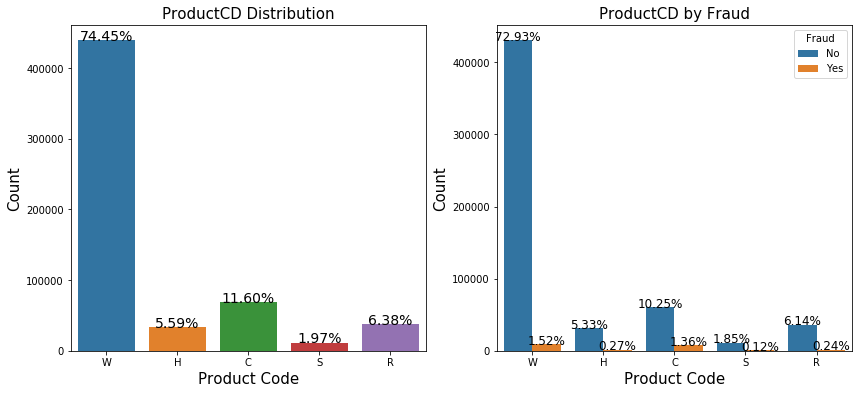

In [9]:
plt.figure(figsize=(14,6))

total = len(train_df)

plt.subplot(121)
g = sns.countplot(x = 'ProductCD', data = train_df)
g.set_title('ProductCD Distribution', fontsize = 15)
g.set_xlabel("Product Code", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train_df)
g1.set_title('ProductCD by Fraud', fontsize = 15)
g1.set_xlabel("Product Code", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 5,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

Now let's look at fraud transaction distribution in all product code

In [10]:
train_df[train_df['isFraud'] == 1]['ProductCD'].value_counts(normalize = True)

W    0.434061
C    0.387553
H    0.076175
R    0.069012
S    0.033199
Name: ProductCD, dtype: float64

isFraud           0         1
ProductCD                    
C          0.883127  0.116873
H          0.952338  0.047662
R          0.962174  0.037826
S          0.941004  0.058996
W          0.979601  0.020399


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

<Figure size 1152x1152 with 0 Axes>

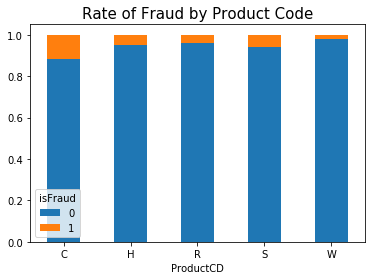

In [11]:
plt.figure(figsize = (16,16))
temp = train_df.groupby('ProductCD')['isFraud'].value_counts(normalize = True).unstack()
print(temp)
a = temp.plot.bar(stacked = True)
a.set_title('Rate of Fraud by Product Code', fontsize = 15)
plt.xticks(rotation = 'horizontal')

These results susgest that with product code, we need to do 2 things:
* Encode categorical levels using Frequency Encoding
* Add target mean by categorical level. It is found here that product C has highest fraud rate, compared to others

In [0]:
# ProductCD Frequency Encoding
col = 'ProductCD'
temp_df = pd.concat([train_df[[col]], test_df[[col]]])   # I don't want to use test data
#temp_df = train_df[[col]]
col_encoded = temp_df[col].value_counts().to_dict()
train_df[col] = train_df[col].map(col_encoded)
test_df[col]  = test_df[col].map(col_encoded)

In [0]:
# ProductCD Target mean
for col in ['ProductCD']:
    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
#    print(temp_dict)
#    print('=============')
    
    temp_dict.index = temp_dict[col].values
#    print(temp_dict.index)
#    print('=============')
    
    temp_dict = temp_dict[col+'_target_mean'].to_dict()
#    print(temp_dict)
#    print('****************')
    
    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

In [14]:
train_df[['ProductCD', 'ProductCD_target_mean']].head()

,ProductCD,ProductCD_target_mean
0,800657,0.020399
1,800657,0.020399
2,800657,0.020399
3,800657,0.020399
4,62397,0.047662


### **2.2 Card1 - Card6**

#### a. Card 1, 2, 3, 5

The card 1,2,3, and 5 was represented as numerical values, temping us to plot the histogram. However, we need to remember that card columns were classified as categorical variables. Meaning it's likely that these numerical variables were coded for categorical variables.

In [15]:
train_df.describe().loc[:,'card1':'card5']

,card1,card2,card3,card5
count,590540.000000,581607.0,588975.0,586281.0
mean,9898.734658,NaN,NaN,NaN
std,4901.170153,NaN,0.0,0.0
min,1000.000000,100.0,100.0,100.0
25%,6019.000000,214.0,150.0,166.0
50%,9678.000000,361.0,150.0,226.0
75%,14184.000000,512.0,150.0,226.0
max,18396.000000,600.0,231.0,237.0


In [16]:
train_df.loc[:,'card1':'card5'].nunique()

card1    13553
card2      500
card3      114
card4        4
card5      119
dtype: int64

Card 1 contains 13553 unique values, suggesting card 1 may have been ID of the card. Card 2,3 and 5 have less unique values, so perhaps they could be expiration date, or combinations that generate card identity? Since we don't know how these information was scrammbled, we might pickup patterns generated by encryption algorithm instead of data. We can calculate target mean grouped by 'card1' - 'card5' (except 'card4')

In [0]:
for col in ['card1', 'card2', 'card3', 'card5']:
    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

In [0]:
########################### Reset values for "noise" card1
i_cols = ['card1']

for col in i_cols: 
    valid_card = pd.concat([train_df[[col]], test_df[[col]]])
    valid_card = valid_card[col].value_counts()
    valid_card = valid_card[valid_card>2]
    valid_card = list(valid_card.index)

    train_df[col] = np.where(train_df[col].isin(test_df[col]), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(train_df[col]), test_df[col], np.nan)

    train_df[col] = np.where(train_df[col].isin(valid_card), train_df[col], np.nan)
    test_df[col]  = np.where(test_df[col].isin(valid_card), test_df[col], np.nan)

b. Card4

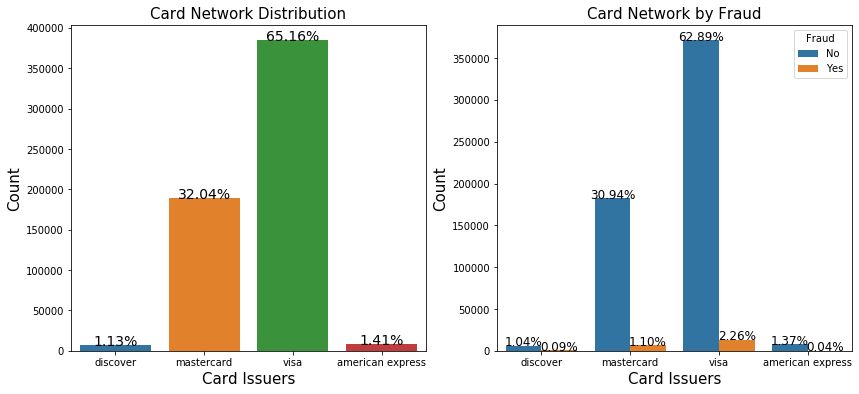

In [19]:
plt.figure(figsize=(14,6))

total = len(train_df)

plt.subplot(121)
g = sns.countplot(x = 'card4', data = train_df)
g.set_title('Card Network Distribution', fontsize = 15)
g.set_xlabel("Card Issuers", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card4', hue='isFraud', data=train_df)
g1.set_title('Card Network by Fraud', fontsize = 15)
g1.set_xlabel("Card Issuers", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

<Figure size 864x864 with 0 Axes>

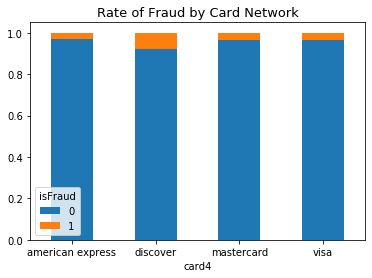

In [20]:
# visualization of table
plt.figure(figsize=(12,12))
b = train_df.groupby('card4')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
b.set_title('Rate of Fraud by Card Network', fontsize = 13)
plt.xticks(rotation='horizontal')

In [0]:
# Card4 Frequency Encoding
col = 'card4'
temp_df = pd.concat([train_df[[col]], test_df[[col]]])
col_encoded = temp_df[col].value_counts().to_dict()
train_df[col] = train_df[col].map(col_encoded)
test_df[col]  = test_df[col].map(col_encoded)

# Card4 Target mean
for col in ['card4']:
    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

c. Card6

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


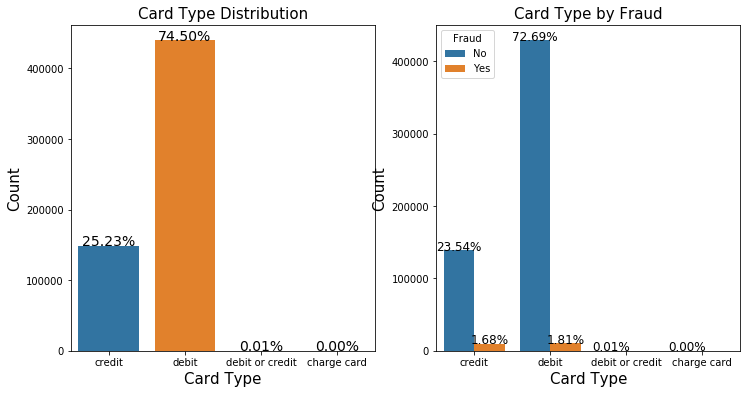

In [22]:
plt.figure(figsize=(12,6))

total = len(train_df)

plt.subplot(121)
g = sns.countplot(x = 'card6', data = train_df)
g.set_title('Card Type Distribution', fontsize = 15)
g.set_xlabel("Card Type", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card6', hue='isFraud', data=train_df)
g1.set_title('Card Type by Fraud', fontsize = 15)
g1.set_xlabel("Card Type", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

<Figure size 1152x1152 with 0 Axes>

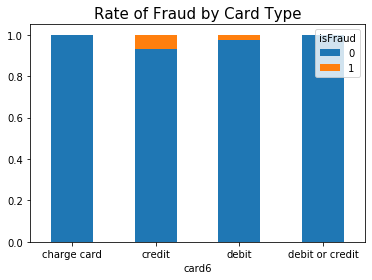

In [23]:
# visualization of table
plt.figure(figsize=(16,16))
c = train_df.groupby('card6')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
c.set_title('Rate of Fraud by Card Type', fontsize = 15)
plt.xticks(rotation='horizontal')

Credit card has much higher fraud rate as compared with other types of card

In [0]:
# Card6 Frequency Encoding
col = 'card6'
temp_df = pd.concat([train_df[[col]], test_df[[col]]])
col_encoded = temp_df[col].value_counts().to_dict()
train_df[col] = train_df[col].map(col_encoded)
test_df[col]  = test_df[col].map(col_encoded)

# Card6 Target mean
for col in ['card6']:
    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

### **2.3 'M1' - 'M9'**

In [25]:
temp = train_df.groupby('M4')['isFraud'].value_counts(normalize = True)
temp

M4  isFraud
M0  0          0.963351
    1          0.036649
M1  0          0.972949
    1          0.027051
M2  0          0.886261
    1          0.113739
Name: isFraud, dtype: float64

In [0]:
# 'M4' Target mean
for col in ['M4']:
    temp_dict = train_df.groupby([col])[TARGET].agg(['mean']).reset_index().rename(
                                                        columns={'mean': col+'_target_mean'})
    temp_dict.index = temp_dict[col].values
    temp_dict = temp_dict[col+'_target_mean'].to_dict()

    train_df[col+'_target_mean'] = train_df[col].map(temp_dict)
    test_df[col+'_target_mean']  = test_df[col].map(temp_dict)

In [27]:
for col in ['M1','M2','M3','M5','M6','M7','M8','M9']:
    train_df[col] = train_df[col].map({'T':1, 'F':0})
    test_df[col]  = test_df[col].map({'T':1, 'F':0})
    
for col in ['M4']:
    print('Encoding', col)
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train_df[col] = train_df[col].map(col_encoded)
    test_df[col]  = test_df[col].map(col_encoded)
    print(col_encoded)

Encoding M4
{'M0': 357789, 'M2': 122947, 'M1': 97306}


### **2.4 'id_12' - 'id_38'**

In [0]:
########################### Identity columns
#################################################################################

def minify_identity_df(df):

    df['id_12'] = df['id_12'].map({'Found':1, 'NotFound':0})
    df['id_15'] = df['id_15'].map({'New':2, 'Found':1, 'Unknown':0})
    df['id_16'] = df['id_16'].map({'Found':1, 'NotFound':0})

    df['id_23'] = df['id_23'].map({'TRANSPARENT':4, 'IP_PROXY':3, 'IP_PROXY:ANONYMOUS':2, 'IP_PROXY:HIDDEN':1})

    df['id_27'] = df['id_27'].map({'Found':1, 'NotFound':0})
    df['id_28'] = df['id_28'].map({'New':2, 'Found':1})

    df['id_29'] = df['id_29'].map({'Found':1, 'NotFound':0})

    df['id_35'] = df['id_35'].map({'T':1, 'F':0})
    df['id_36'] = df['id_36'].map({'T':1, 'F':0})
    df['id_37'] = df['id_37'].map({'T':1, 'F':0})
    df['id_38'] = df['id_38'].map({'T':1, 'F':0})

    df['id_34'] = df['id_34'].fillna(':0')
    df['id_34'] = df['id_34'].apply(lambda x: x.split(':')[1]).astype(np.int8)
    df['id_34'] = np.where(df['id_34']==0, np.nan, df['id_34'])
    
    df['id_33'] = df['id_33'].fillna('0x0')
    df['id_33_0'] = df['id_33'].apply(lambda x: x.split('x')[0]).astype(int)
    df['id_33_1'] = df['id_33'].apply(lambda x: x.split('x')[1]).astype(int)
    df['id_33'] = np.where(df['id_33']=='0x0', np.nan, df['id_33'])

    df['DeviceType'].map({'desktop':1, 'mobile':0})
    return df

train_identity = minify_identity_df(train_identity)
test_identity = minify_identity_df(test_identity)

for col in ['id_33']:
    train_identity[col] = train_identity[col].fillna('unseen_before_label')
    test_identity[col]  = test_identity[col].fillna('unseen_before_label')
    
    le = LabelEncoder()
    le.fit(list(train_identity[col])+list(test_identity[col]))
    train_identity[col] = le.transform(train_identity[col])
    test_identity[col]  = le.transform(test_identity[col])

### **3. Feature Engineering**

#### **3.1 TransactionDT**

In [0]:
START_DATE = datetime.datetime.strptime('2018-01-01', '%Y-%m-%d')

for df in [train_df, test_df]:
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: START_DATE + (datetime.timedelta(seconds = x)))
    df['DT_M'] = df['DT'].dt.month
    df['DT_W'] = df['DT'].dt.weekofyear
    df['DT_D'] = df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # D9 column
    df['D9'] = np.where(df['D9'].isna(),0,1)

#del train_df['DT']
#del test_df['DT']

#### 3.2 Transaction Amount

In [0]:
train_df['TransactionAmt_to_mean_ProductCD'] = train_df['TransactionAmt'] / train_df.groupby(['ProductCD'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_mean_Hour'] = train_df['TransactionAmt'] / train_df.groupby(['DT_hour'])['TransactionAmt'].transform('mean')
train_df['TransactionAmt_to_std_ProductCD'] = train_df['TransactionAmt'] / train_df.groupby(['ProductCD'])['TransactionAmt'].transform('std')
train_df['TransactionAmt_to_std_Hour'] = train_df['TransactionAmt'] / train_df.groupby(['DT_hour'])['TransactionAmt'].transform('std')

test_df['TransactionAmt_to_mean_ProductCD'] = test_df['TransactionAmt'] / train_df.groupby(['ProductCD'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_mean_Hour'] = test_df['TransactionAmt'] / train_df.groupby(['DT_hour'])['TransactionAmt'].transform('mean')
test_df['TransactionAmt_to_std_ProductCD'] = test_df['TransactionAmt'] / train_df.groupby(['ProductCD'])['TransactionAmt'].transform('std')
test_df['TransactionAmt_to_std_Hour'] = test_df['TransactionAmt'] / train_df.groupby(['DT_hour'])['TransactionAmt'].transform('std')

In [0]:
# Let's add some kind of client uID based on cardID ad addr columns
# The value will be very specific for each client so we need to remove it
# from final feature. But we can use it for aggregations.
train_df['uid'] = train_df['card1'].astype(str)+'_'+train_df['card2'].astype(str)
test_df['uid'] = test_df['card1'].astype(str)+'_'+test_df['card2'].astype(str)

train_df['uid2'] = train_df['uid'].astype(str)+'_'+train_df['card3'].astype(str)+'_'+train_df['card4'].astype(str)
test_df['uid2'] = test_df['uid'].astype(str)+'_'+test_df['card3'].astype(str)+'_'+test_df['card4'].astype(str)

train_df['uid3'] = train_df['uid2'].astype(str)+'_'+train_df['addr1'].astype(str)+'_'+train_df['addr2'].astype(str)
test_df['uid3'] = test_df['uid2'].astype(str)+'_'+test_df['addr1'].astype(str)+'_'+test_df['addr2'].astype(str)

# Check if the Transaction Amount is common or not (we can use freq encoding here)
# In our dialog with a model we are telling to trust or not to these values   
train_df['TransactionAmt_check'] = np.where(train_df['TransactionAmt'].isin(test_df['TransactionAmt']), 1, 0)
test_df['TransactionAmt_check']  = np.where(test_df['TransactionAmt'].isin(train_df['TransactionAmt']), 1, 0)


i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']
for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train_df[[col, 'TransactionAmt']], test_df[[col,'TransactionAmt']]])
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})
        
        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   
    
        train_df[new_col_name] = train_df[col].map(temp_df)
        test_df[new_col_name]  = test_df[col].map(temp_df)

In [0]:
# 'P_emaildomain' - 'R_emaildomain'
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

for df in [train_df, test_df]:
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])

In [0]:
# -------- Device info ------------
for df in [train_identity, test_identity]:
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    df['DeviceInfo_device'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['DeviceInfo_version'] = df['DeviceInfo'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    df['id_30'] = df['id_30'].fillna('unknown_device').str.lower()
    df['id_30_device'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))
    df['id_30_version'] = df['id_30'].apply(lambda x: ''.join([i for i in x if i.isnumeric()]))
    
    # For browser
    df['id_31'] = df['id_31'].fillna('unknown_device').str.lower()
    df['id_31_device'] = df['id_31'].apply(lambda x: ''.join([i for i in x if i.isalpha()]))

In [0]:
# Merge Identity columns
temp_df = train_df[['TransactionID']]
temp_df = temp_df.merge(train_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
train_df = pd.concat([train_df,temp_df], axis=1)
    
temp_df = test_df[['TransactionID']]
temp_df = temp_df.merge(test_identity, on=['TransactionID'], how='left')
del temp_df['TransactionID']
test_df = pd.concat([test_df,temp_df], axis=1)

#### **3.3 Frequency Encoding**


In [0]:
# Freq encoding
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','DeviceInfo_device','DeviceInfo_version',
          'id_30','id_30_device','id_30_version',
          'id_31_device',
          'id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train_df[col+'_fq_enc'] = train_df[col].map(fq_encode)
    test_df[col+'_fq_enc']  = test_df[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train_df[[col]], test_df[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train_df[col+'_total'] = train_df[col].map(fq_encode)
    test_df[col+'_total']  = test_df[col].map(fq_encode)
        

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train_df[[col,period]], test_df[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train_df[new_column] = (train_df[col].astype(str) + '_' + train_df[period].astype(str)).map(fq_encode)
        test_df[new_column]  = (test_df[col].astype(str) + '_' + test_df[period].astype(str)).map(fq_encode)
        
        train_df[new_column] /= train_df[period+'_total']
        test_df[new_column]  /= test_df[period+'_total']

In [0]:
# M columns (except M4)
# All these columns are binary encoded 1/0
# We can have some features from it
i_cols = ['M1','M2','M3','M5','M6','M7','M8','M9']

for df in [train_df, test_df]:
    df['M_sum'] = df[i_cols].sum(axis=1).astype(np.int8)
    df['M_na'] = df[i_cols].isna().sum(axis=1).astype(np.int8)

In [37]:
########################### Encode Str columns
# For all such columns (probably not)
# we already did frequency encoding (numeric feature)
# so we will use astype('category') here
for col in list(train_df):
    if train_df[col].dtype=='O':
        print(col)
        train_df[col] = train_df[col].fillna('unseen_before_label')
        test_df[col]  = test_df[col].fillna('unseen_before_label')
        
        train_df[col] = train_df[col].astype(str)
        test_df[col] = test_df[col].astype(str)
        
        le = LabelEncoder()
        le.fit(list(train_df[col])+list(test_df[col]))
        train_df[col] = le.transform(train_df[col])
        test_df[col]  = le.transform(test_df[col])
        
        #train_df[col] = train_df[col].astype('category')
        #test_df[col] = test_df[col].astype('category')

P_emaildomain
R_emaildomain
uid
uid2
uid3
P_emaildomain_prefix
R_emaildomain_prefix
id_30
id_31
DeviceType
DeviceInfo
DeviceInfo_device
DeviceInfo_version
id_30_device
id_30_version
id_31_device


In [38]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)
gc.collect()

Mem. usage decreased to 719.75 Mb (32.9% reduction)
Mem. usage decreased to 625.28 Mb (32.6% reduction)


0

### **4. Clean up**

In [0]:
for col in list(train_df):
    if train_df[col].dtype == 'O':
        print(col)

In [0]:
rm_cols = [
    'TransactionID','TransactionDT', # These columns are pure noise right now
    TARGET,                          # Not target in features))
    'uid','uid2','uid3',             # Our new client uID -> very noisy data
    'bank_type',                     # Victims bank could differ by time
    'DT','DT_M','DT_W','DT_D',       # Temporary Variables
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
]

In [41]:
########################### Features elimination 
from scipy.stats import ks_2samp
features_check = []
columns_to_check = set(list(train_df)).difference(base_columns+rm_cols)
for i in columns_to_check:
    features_check.append(ks_2samp(test_df[i], train_df[i])[1])

features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
features_discard = list(features_check[features_check==0].index)
print(features_discard)

# We will reset this list for now,
# Good droping will be in other kernels
# with better checking
features_discard = [] 

# Final features list
features_columns = [col for col in list(train_df) if col not in rm_cols + features_discard]

['M_na', 'TransactionAmt_to_mean_ProductCD', 'uid_DT_D', 'C12_fq_enc', 'D7_fq_enc', 'D3_fq_enc', 'M_sum', 'TransactionAmt_to_std_ProductCD', 'uid_DT_W', 'id_30_version', 'D5_fq_enc', 'D6_fq_enc', 'D4_fq_enc', 'id_31_device']


#### **5. XGBoost**

In [0]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [0]:
x_train = train_df[features_columns]
y_train = train_df[TARGET]

x_test = test_df[features_columns]

In [44]:
x_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,...,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D7_fq_enc,D8_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,dist2_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceInfo_fq_enc,DeviceInfo_device_fq_enc,DeviceInfo_version_fq_enc,id_30_fq_enc,id_30_device_fq_enc,id_30_version_fq_enc,id_31_device_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,uid3_fq_enc,uid_DT_M,uid_DT_W,uid_DT_D,M_sum,M_na
0,68.5,800657,13928.0,NaN,150.0,9524.0,142.0,267648.0,315.0,87.0,19.0,NaN,12,12,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,0,13.0,13.0,NaN,...,707008,631237,961237,816304,420354,824420,168780,856080,367617,598520,5548,515566,11525,245773,534216,899261,998181,947967,43035,956415,4707,1023168,163648,824070,811091,811091,811091,811091,811091,811091,811091,811091,6,6,2,0.000008,0.000021,0.000118,4,3
1,29.0,800657,2756.0,404.0,150.0,347386.0,102.0,267648.0,325.0,87.0,NaN,NaN,17,12,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,...,707008,631237,961237,816304,341561,824420,731792,856080,367617,598520,507854,515566,466020,344849,534216,899261,998181,947967,76902,956415,643488,1023168,435803,824070,811091,811091,811091,811091,811091,811091,811091,811091,1328,1328,105,0.001053,0.001380,0.001065,2,6
2,59.0,800657,4664.0,490.0,150.0,719649.0,166.0,824959.0,330.0,87.0,287.0,NaN,36,12,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0,0.0,315.0,NaN,...,707008,631237,961237,816304,420354,824420,731792,856080,367617,598520,507854,515566,466020,344849,534216,899261,998181,947967,48387,956415,38,1023168,9934,824070,811091,811091,811091,811091,811091,811091,811091,811091,1787,1787,46,0.001163,0.001464,0.001538,3,0
3,50.0,800657,18128.0,567.0,150.0,347386.0,117.0,824959.0,476.0,87.0,NaN,NaN,55,12,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,0,84.0,NaN,NaN,...,707008,34225,961237,816304,420354,824420,731792,856080,5659,598520,1440,1374,146326,894,139264,899261,998181,947967,17455,956415,643488,1023168,182784,824070,811091,811091,811091,811091,811091,811091,811091,811091,7602,7602,362,0.005783,0.007298,0.010292,1,6
4,50.0,62397,4496.0,514.0,150.0,347386.0,102.0,267648.0,420.0,87.0,NaN,NaN,17,12,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,...,707008,631237,961237,202326,341561,192574,731792,856080,367617,598520,507854,515566,466020,245773,534216,899261,998181,947967,7107,956415,643488,1023168,435803,824070,9,358,9,3573,11783,3573,4294,1430,30,30,1,0.000027,0.000042,0.000118,0,8


In [0]:
#hasattr(x_train['P_emaildomain'],'cat')

**Input Normalization**

In [46]:
x_train_cols = list(x_train)

for i in x_train_cols:
    if not hasattr(x_train[i],'cat'):
      mean = np.nanmean(x_train[[i]].values.astype('float64'))
      std = np.nanstd(x_train[[i]].values.astype('float64'))
      #print(i, mean, std)
      x_train[[i]] = (x_train[[i]] - mean)/std
  
# Check
x_train.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,...,C5_fq_enc,C6_fq_enc,C7_fq_enc,C8_fq_enc,C9_fq_enc,C10_fq_enc,C11_fq_enc,C12_fq_enc,C13_fq_enc,C14_fq_enc,D1_fq_enc,D2_fq_enc,D3_fq_enc,D4_fq_enc,D5_fq_enc,D6_fq_enc,D7_fq_enc,D8_fq_enc,addr1_fq_enc,addr2_fq_enc,dist1_fq_enc,dist2_fq_enc,P_emaildomain_fq_enc,R_emaildomain_fq_enc,DeviceInfo_fq_enc,DeviceInfo_device_fq_enc,DeviceInfo_version_fq_enc,id_30_fq_enc,id_30_device_fq_enc,id_30_version_fq_enc,id_31_device_fq_enc,id_33_fq_enc,uid_fq_enc,uid2_fq_enc,uid3_fq_enc,uid_DT_M,uid_DT_W,uid_DT_D,M_sum,M_na
0,-0.278076,0.584537,0.821289,NaN,-0.286621,-2.925913,-1.387695,-1.717722,0.238281,0.069641,-0.267578,NaN,-0.598354,-0.230026,-0.097961,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.053955,-0.208740,-0.054871,-0.087402,-0.047058,-0.243774,-0.147339,-0.509766,NaN,-0.245972,NaN,NaN,NaN,NaN,NaN,-0.381201,-0.607910,-0.718262,NaN,...,0.748448,0.844459,0.358527,0.559308,0.859587,0.545156,-1.121803,0.452326,1.376934,0.904384,-0.937475,1.050132,-1.024204,0.516835,0.940568,0.374887,0.265511,0.381201,-0.209742,0.366607,-1.254167,0.260867,-0.467163,0.549083,0.567652,0.567663,0.561385,0.565868,0.566837,0.565603,0.567534,0.56555,-0.674009,-0.666384,-0.436816,-0.681152,-0.561523,-0.428467,0.637593,-0.311587
1,-0.443359,0.584537,-1.458984,0.263184,-0.286621,-1.199357,-2.357422,-1.717722,0.336670,0.069641,NaN,NaN,-0.303544,-0.230026,-0.097961,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.053955,-0.268799,-0.054871,-0.098022,-0.047058,-0.243774,-0.147339,-0.598633,NaN,NaN,-0.732422,NaN,NaN,NaN,NaN,-0.381201,-0.679199,NaN,NaN,...,0.748448,0.844459,0.358527,0.559308,0.325968,0.545156,0.710881,0.452326,1.376934,0.904384,1.052616,1.050132,1.094798,1.176750,0.940568,0.374887,0.265511,0.381201,0.662275,0.366607,0.822101,0.260867,1.195447,0.549083,0.567652,0.567663,0.561385,0.565868,0.566837,0.565603,0.567534,0.56555,-0.485784,-0.477891,-0.406367,-0.522461,-0.408936,-0.358887,-0.221011,0.607990
2,-0.317871,0.584537,-1.069336,0.808105,-0.286621,0.702997,-0.806152,0.581999,0.385742,0.069641,0.453369,NaN,0.816731,-0.230026,-0.097961,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.053955,-0.208740,-0.054871,-0.098022,-0.047058,-0.243774,-0.147339,-0.598633,NaN,NaN,-0.732422,NaN,NaN,NaN,NaN,-0.381201,-0.679199,0.905273,NaN,...,0.748448,0.844459,0.358527,0.559308,0.859587,0.545156,0.710881,0.452326,1.376934,0.904384,1.052616,1.050132,1.094798,1.176750,0.940568,0.374887,0.265511,0.381201,-0.071937,0.366607,-1.269343,0.260867,-1.406211,0.549083,0.567652,0.567663,0.561385,0.565868,0.566837,0.565603,0.567534,0.56555,-0.420432,-0.412446,-0.423809,-0.505859,-0.399414,-0.324219,0.208291,-1.231165
3,-0.355469,0.584537,1.678711,1.295898,-0.286621,-1.199357,-1.994141,0.581999,1.820312,0.069641,NaN,NaN,1.937006,-0.230026,-0.090515,-0.066467,-0.037506,-0.059448,-0.216064,-0.070923,-0.046143,-0.053955,-0.208740,-0.054871,-0.098022,-0.047058,-0.058228,-0.147339,0.111816,-0.324951,-0.454346,-0.240723,-0.47583,NaN,NaN,NaN,-0.381201,-0.218994,NaN,NaN,...,0.748448,-1.356282,0.358527,0.559308,0.859587,0.545156,0.710881,0.452326,-0.899493,0.904384,-0.953751,-0.959769,-0.395718,-1.114230,-0.638560,0.374887,0.265511,0.381201,-0.868383,0.366607,0.822101,0.260867,-0.350260,0.549083,0.567652,0.567663,0.561385,0.565868,0.566837,0.565603,0.567534,0.56555,0.407502,0.416666,-0.330392,0.195801,0.254395,0.317871,-0.650313,0.607990
4,-0.355469,-1.813735,-1.103516,0.960449,-0.286621,-1.199357,-2.357422,-1.717722,1.270508,0.069641,NaN,NaN,-0.303544,-0.230026,-0.097961,-0.092285,-0.037506,-0.059448,-0.216064,-0.112854,-0.046143,-0.043457,-0.268799,-0.044403,-0.098022,-0.047058,-0.243774,-0.147339,-0.598633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.381201,NaN,NaN,NaN,...,0.748448,0.844459,0.358527,-1.581339,0.325968,-1.639410,0.710881,0.452326,1.376934,0.9

We actually do not have labels in the test set (as this was taken from a Kaggle competition). What we do here is to split the training set into train & validation sets. The model would be evaluated on the validation part.

In [0]:
tr_x, vl_x, tr_y, vl_y = train_test_split( x_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

**Below are the best parameters we have after several tuning rounds**

In [0]:
best_n_estimators = 1000
best_max_depth = 6
best_min_child_weight = 4
best_gamma = 0
best_subsample = 0.8
best_colsample_bytree = 0.8

In [0]:
def modelfit(tr_x, vl_x, tr_y, vl_y, n, d, w, g, sub, col):
    # Create a Classifier
    xgb_final = XGBClassifier(learning_rate =0.01,
                          n_estimators=n,
                          max_depth=d,
                          min_child_weight=w,
                          gamma=g,
                          subsample=sub,
                          colsample_bytree=col,
                          objective= 'binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)


    # Fit on the training data
    xgb_final.fit(tr_x, tr_y, eval_metric = 'auc')

    # Make predictions on train & validation set
    tr_predictions = xgb_final.predict(tr_x)
    tr_predprob = xgb_final.predict_proba(tr_x)[:,1]

    vl_predictions = xgb_final.predict(vl_x)
    vl_predprob = xgb_final.predict_proba(vl_x)[:,1]

    # Print score on training set
    print ("Accuracy (Train): %.4g" % metrics.accuracy_score(tr_y, tr_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(tr_y, tr_predprob))

    # Predict on validation set:
    print ("Accuracy (Validation): %.4g" % metrics.accuracy_score(vl_y, vl_predictions))
    print ("AUC Score (Validation): %f" % metrics.roc_auc_score(vl_y, vl_predprob))

In [50]:
modelfit(tr_x, vl_x, tr_y, vl_y, best_n_estimators, best_max_depth, best_min_child_weight, best_gamma, best_subsample, best_colsample_bytree)

Accuracy (Train): 0.9806
AUC Score (Train): 0.954123
Accuracy (Validation): 0.9797
AUC Score (Validation): 0.947400
